# Label-free classification using IDEAS features

In this notebook, we will compare feature sets generated using IDEAS and SCIP. 

In [2]:
%load_ext autoreload
%autoreload 2

In [1]:
# %load ../common_.py
import sys
sys.path.append("../../..")
from workflow.common import *

In [4]:
import seaborn
import fcsparser
from sklearn.preprocessing import scale
from scipy.stats import pearsonr, spearmanr
from scip_workflows import core

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import ConfusionMatrixDisplay

from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

from xgboost import XGBClassifier

import pickle

In [5]:
from scip_workflows import masking

# Data

In [ ]:
data_root = Path(os.environ["VSC_DATA_VO_USER"]) / "datasets/wbc"

In [6]:
data_root = Path("/home/maximl/scratch/data/vsc/datasets/wbc/")

In [7]:
data_scip = data_root / "scip/202204271347/"
data_ideas = data_root / "ideas/202111121025/"

In [8]:
df_scip = pq.read_table(data_scip / "features.parquet").to_pandas()

cat_type = CategoricalDtype(
    categories=sorted(df_scip["meta_group"].astype(int).unique()), ordered=True)
df_scip["meta_group"] = df_scip["meta_group"].astype(int).astype(cat_type)

cat_type = CategoricalDtype(
    categories=sorted(df_scip["meta_part"].astype(int).unique()), ordered=True)
df_scip["meta_part"] = df_scip["meta_part"].astype(int).astype(cat_type)

df_scip = df_scip.set_index(["meta_group", "meta_part", "meta_fix", "meta_object_number"])

df_scip = df_scip[numpy.load(
    data_scip / "indices/columns.npy", allow_pickle=True)]
df_scip = df_scip.loc[numpy.load(
    data_scip / "indices/index.npy", allow_pickle=True)]

df_scip["meta_label"] = pandas.Categorical(df_scip["meta_label"], ordered=True)

df_scip.shape

(233262, 2200)

In [9]:
# ideas features
def proc_cols(cols):
    out = []
    for col in cols:
        col = col.lower()
        for c in [" ", "-", "_", "."]:
            col = col.replace(c, "")
        out.append(col)
    return out

tmp = []
cols = None
for p in (data_ideas / "fcs").glob('*.fcs'):
    meta, data = fcsparser.parse(p)
    groups = re.search("wbc(?P<group>[0-9])_(?P<part>[0-9])_?(?P<fix>(early|late))?.fcs", p.name).groupdict()
    data["fix"] = groups["fix"]
    data["group"] = int(groups["group"])
    data["part"] = int(groups["part"])
    data.columns = proc_cols(data.columns)
    if cols is None:
        cols = data.columns  
    tmp.append(data[cols])
df_ideas = pandas.concat(tmp, axis=0)

ideas_meta_cols = ["objectnumber", "fix", "group", "part"]
df_ideas = df_ideas.rename(columns=lambda col: f"meta_{col.lower()}" if col in ideas_meta_cols else f"feat_{col.lower()}")

df_ideas["meta_object_number"] = df_ideas["meta_objectnumber"].astype(int)
df_ideas = df_ideas.drop(columns="meta_objectnumber")

df_ideas = df_ideas.set_index(["meta_group", "meta_part", "meta_fix", "meta_object_number"])

In [10]:
r = r"(?i).*(uncompensated|bkgd|saturation|\().*" 
todrop = list(filter(lambda x: re.match(r, x), df_ideas.columns))
df_ideas = df_ideas.drop(columns=todrop)
df_ideas.shape

(274050, 305)

In [11]:
df = df_scip.rename(columns=lambda a: "scip_"+a).merge(
    df_ideas.rename(columns=lambda a: "ideas_"+a), 
    left_index=True, right_index=True,
    how="inner"
)
df.shape

(233262, 2505)

In [12]:
def rename(c):
    if c.startswith("scip_meta"):
        return "meta_" + c[10:]
    return c
df = df.rename(columns=rename)

# HPO results

In [97]:
with open(data_ideas / "hpo" / "rsh_cyto.pickle", "rb") as fh:
    grid = pickle.load(fh)

In [98]:
grid["test_balanced_accuracy"].mean(), scipy.stats.sem(grid["test_balanced_accuracy"])

(0.8527125927325537, 0.0022640421768951946)

In [99]:
grid["test_balanced_accuracy"], grid["train_balanced_accuracy"]

(array([0.85927836, 0.85052361, 0.85577535, 0.84602947, 0.85195618]),
 array([0.91989679, 0.92425271, 0.91915127, 0.90348899, 0.917719  ]))

In [100]:
for e in grid["estimator"]:
    print(e.best_params_)

{'xgbclassifier__subsample': 0.9, 'xgbclassifier__n_estimators': 150, 'xgbclassifier__min_child_weight': 27, 'xgbclassifier__max_depth': 4, 'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__gamma': 2, 'xgbclassifier__colsample_bytree': 0.8}
{'xgbclassifier__subsample': 0.9, 'xgbclassifier__n_estimators': 140, 'xgbclassifier__min_child_weight': 19, 'xgbclassifier__max_depth': 6, 'xgbclassifier__learning_rate': 0.05, 'xgbclassifier__gamma': 6, 'xgbclassifier__colsample_bytree': 0.4}
{'xgbclassifier__subsample': 0.8, 'xgbclassifier__n_estimators': 290, 'xgbclassifier__min_child_weight': 23, 'xgbclassifier__max_depth': 3, 'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__gamma': 6, 'xgbclassifier__colsample_bytree': 1.0}
{'xgbclassifier__subsample': 0.4, 'xgbclassifier__n_estimators': 160, 'xgbclassifier__min_child_weight': 3, 'xgbclassifier__max_depth': 5, 'xgbclassifier__learning_rate': 0.05, 'xgbclassifier__gamma': 8, 'xgbclassifier__colsample_bytree': 0.9}
{'xgbclassifier__subsam

# Classification

In [17]:
enc = LabelEncoder().fit(df["meta_label"])
y = enc.transform(df["meta_label"])

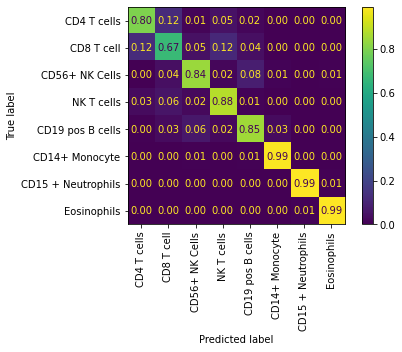

In [107]:
X = df.filter(regex="ideas.*(bf420nm480nm|bf570nm595nm|m01|m06|m09|ssc)$").drop(2, level="meta_group").drop('late', level="meta_fix")
y = enc.transform(df.drop(2, level="meta_group").drop('late', level="meta_fix")["meta_label"])
preds = []
true = []

skf = StratifiedKFold(n_splits=5, random_state=0, shuffle=True)
for estimator, (_, test_index) in zip(grid["estimator"], skf.split(X, y)):
    X_test, y_test = X.iloc[test_index], y[test_index]
    preds.extend(estimator.predict(X_test))    
    true.extend(y_test)

fig, ax = plt.subplots()
ConfusionMatrixDisplay.from_predictions(
    true, preds, 
    labels=[3, 5, 4, 7, 2, 0, 1, 6],
    display_labels=enc.classes_[[3, 5, 4, 7, 2, 0, 1, 6]],
    normalize='true', xticks_rotation="vertical", values_format=".2f",
    ax=ax
)
plt.savefig(data_ideas / "figures" / "xgb_wbc_cyto_cv_confmat_ideas.png", bbox_inches="tight")

In [109]:
grid_cyto_df_scip = pq.read_table('/home/maximl/scratch/data/vsc/datasets/wbc/scip/20220713131400/scores.parquet').to_pandas()
grid_cyto_df_scip["software"] = "SCIP"

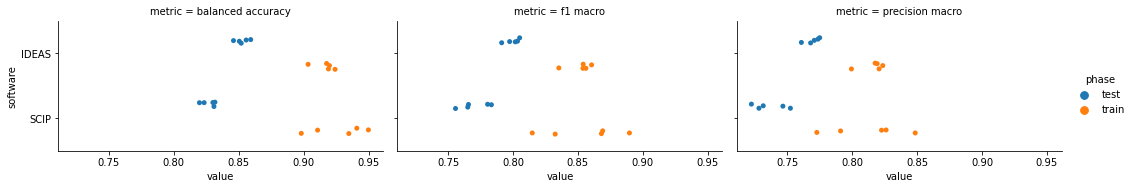

In [105]:
grid_cyto_df = pandas.DataFrame(grid).drop(columns=["score_time", "fit_time", "estimator", "train_recall_macro", "test_recall_macro"]).melt()
grid_cyto_df["phase"] = grid_cyto_df["variable"].apply(lambda r: r.split("_")[0])
grid_cyto_df["metric"] = grid_cyto_df["variable"].apply(lambda r: " ".join(r.split("_")[1:]))
grid_cyto_df["software"] = "IDEAS"

grid_cyto_df = pandas.concat([grid_cyto_df, grid_cyto_df_scip])

g = seaborn.catplot(data=grid_cyto_df, x='value', y='software', col='metric', dodge=True, hue="phase", kind="strip")
for ax in g.axes.ravel():
    ax.set_box_aspect(0.4)

plt.savefig(data_ideas / "figures" / "xgb_wbc_cyto_cv_scores.png", bbox_inches="tight")

In [113]:
scores_df = grid_cyto_df.groupby(["metric", "phase"])["value"].agg(['mean', scipy.stats.sem])
scores_df.index.names = ["Metric", "Phase"]
scores_df["Mean (std. error)"] = scores_df.apply(lambda r: "%.3f (%.3f)" % (r["mean"], r["sem"]), axis=1)
ideas_scores = scores_df.reset_index().pivot(index="Metric", values="Mean (std. error)", columns="Phase")

In [114]:
scores_df = grid_cyto_df_scip.groupby(["metric", "phase"])["value"].agg(['mean', scipy.stats.sem])
scores_df.index.names = ["Metric", "Phase"]
scores_df["Mean (std. error)"] = scores_df.apply(lambda r: "%.3f (%.3f)" % (r["mean"], r["sem"]), axis=1)
scip_scores = scores_df.reset_index().pivot(index="Metric", values="Mean (std. error)", columns="Phase")

In [115]:
scip_scores.columns = pandas.MultiIndex(levels=[('SCIP', 'IDEAS'), ('train', 'test')], codes=[(0, 0), (1, 0)], names=["Software", "Phase"])
ideas_scores.columns = pandas.MultiIndex(levels=[('SCIP', 'IDEAS'), ('train', 'test')], codes=[(1, 1), (1, 0)], names=["Software", "Phase"])

scores = scip_scores.merge(ideas_scores, left_index=True, right_index=True)
scores.index.name = ""

print(scores.style.to_latex(hrules=True))

\begin{tabular}{lllll}
\toprule
Software & \multicolumn{2}{r}{SCIP} & \multicolumn{2}{r}{IDEAS} \\
Phase & test & train & test & train \\
 &  &  &  &  \\
\midrule
balanced accuracy & 0.827 (0.002) & 0.927 (0.010) & 0.840 (0.005) & 0.922 (0.005) \\
f1 macro & 0.770 (0.005) & 0.855 (0.014) & 0.785 (0.006) & 0.853 (0.007) \\
precision macro & 0.736 (0.006) & 0.812 (0.013) & 0.753 (0.006) & 0.814 (0.007) \\
\bottomrule
\end{tabular}



# Feature importance

In [20]:
def fi(estimators):
    a = numpy.array([e.named_steps["xgbclassifier"].feature_importances_ for e in estimators])
    return a

fi_ideas = fi(results_ideas["estimator"])
fi_scip = fi(results_scip["estimator"])

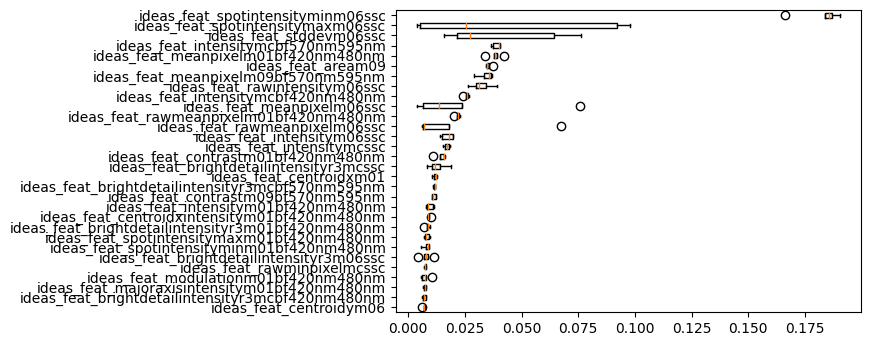

In [21]:
sorted_idx = fi_ideas.mean(axis=0).argsort()[-30:]

fig, ax = plt.subplots(1, dpi=100)
ax.boxplot(
    fi_ideas.T[sorted_idx].T,
    vert=False,
    labels=df.filter(regex="ideas.*(bf420nm480nm|bf570nm595nm|m01|m06|m09|ssc)$").columns[sorted_idx],
);

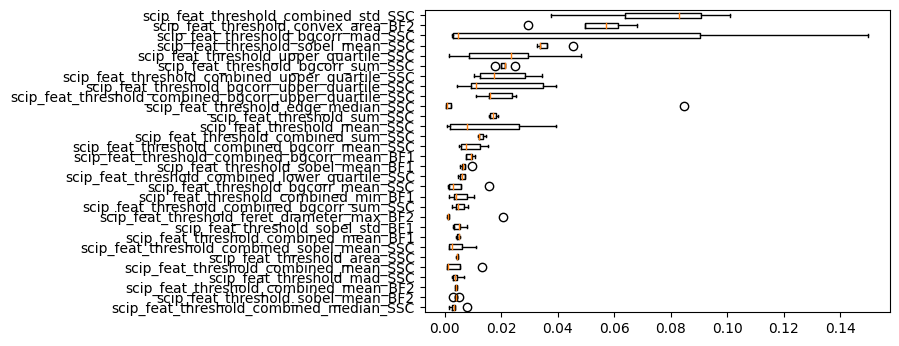

In [25]:
sorted_idx = fi_scip.mean(axis=0).argsort()

fig, ax = plt.subplots(1, dpi=100)
ax.boxplot(
    fi_scip.T[sorted_idx[-30:]].T,
    vert=False,
    labels=df.filter(regex="scip.*(BF1|BF2|SSC)$").columns[sorted_idx[-30:]],
);